# MIT 6.7960 Fall 2025 PyTorch Tutorial:

This colab is adapted from both https://github.com/davidbau/how-to-read-pytorch and https://pytorch.org/tutorials/beginner/basics/intro.html, which are great resources if you’re interested in learning more.



Pytorch and its key features
===================

Pytorch is a numerical library that makes it very convenient to train deep networks on GPU hardware. It introduces a new programming vocabulary that takes a few steps beyond regular numerical python code. Although pytorch code can look simple and concrete, much of of the subtlety of what happens is invisible, so when working with pytorch code it helps to thoroughly understand the runtime model.

For example, consider this code:

```
torch.nn.cross_entropy(model(images.cuda()), labels.cuda()).backward()
optimizer.step()
```

It looks like it computes some function of `images` and `labels` without storing the answer.  But actually the purpose of this code is to update some hidden parameters that are not explicit in this formula.  This line of code moves batches of image and label data from CPU to the GPU; runs a neural network to make a prediction; constructs a computation graph describing how the loss depends on the network parameters; annotates every network parameter with a gradient; then finally it runs one step of optimization to adjust every parameter of the model.  During all this, the CPU does not see any of the actual answers.  That is intentional for speed reasons.  All the numerical computation is done on the GPU asynchronously and kept there.

The brevity of the code is what makes pytorch code fun to write.  But it also reflects why pytorch can be so fast even though the python interpreter is so slow. Although the main python logic slogs along sequentially in a single very slow CPU thread, just a few python instructions can load a huge amount of work into the GPU.  That means the program can keep the GPU busy churning through massive numerical computations, for most part, without waiting for the python interpreter.

It is worth understanding five core idioms that work together to make this possible.  This tutorial covers five Colab notebooks, one for each topic:

 1. [GPU Tensor arithmetic](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks/1-Pytorch-Introduction.ipynb): the notation for manipulating n-dimensional arrays of numbers on CPU or GPU.
 2. [Autograd](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks//2-Pytorch-Autograd.ipynb): how to build a tensor computation graph and use it to get derivatives of any scalar with respect to any input.
 3. [Optimization](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks//3-Pytorch-Optimizers.ipynb): ways to update tensor parameters to reduce any computed objective, using autograd gradients.
 4. [Network modules](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks//4-Pytorch-Modules.ipynb): how pytorch represents neural networks for convenient composition, training, and saving.
 5. [Datasets and Dataloaders](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks//5-Pytorch-Dataloader.ipynb): for efficient multithreaded prefetching of large streams of data.

The key ideas are illustrated with small, illustrated, hackable examples, and there are links to other reference material and resources.

All the notebooks can be run on Google Colab where some GPU compuation can be used for free, or they can be run on your own local Jupyter notebook server.

The examples should all work with python 3.5 or newer and pytorch 1.0 or newer.

The original code on github can be found [here](https://github.com/davidbau/how-to-read-pytorch).

In [1]:
# some basic GPU Tensor arithmetic
import math, numpy, torch
import matplotlib.pyplot as plt
x = torch.linspace(0,5,101)
print(x[:5])

tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000])


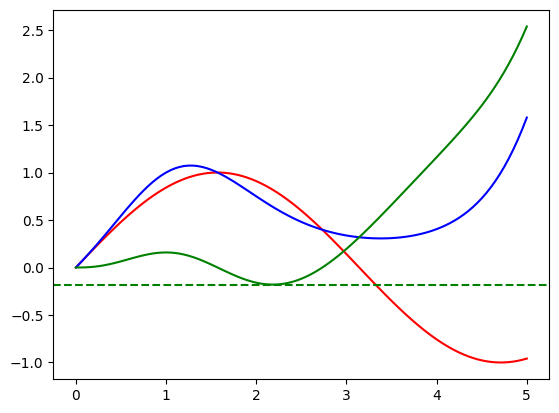

In [4]:
y1, y2 = x.sin(), x ** x.cos()
y3 = y2 - y1
y4 = y3.min()

plt.plot(x, y1, 'red', x, y2, 'blue', x, y3, 'green')
plt.axhline(y4, color='green', linestyle="--")
plt.show()

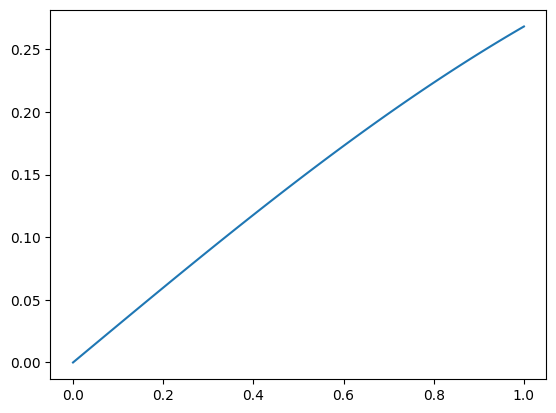

In [15]:
import numpy as np
plt.plot(x, np.clip(y3, 0,1))
plt.show()

Subscripts and multiple dimensions
----------------------------------

Pytorch code is full of multidimensional arrays.  The key to reading this kind of code is stopping to think about the careful, sometimes tangled, use of multiple array subscripts.

**Slicing.** As normal in python, you can use `[min:max:stride]` to slice ranges, and multidimensional subscripts like `x[2,0,1,9]` work as you would expect (selecting the 9th entry of the of the 1st of the 0th of the 2nd entry of `x`; and can be used with slices like `x[0:3,2,:,:]`.  The special slice `:` selects the whole range in that dimension.

**Unsqueezing to add a dimension, and broadcasting.** While a single integer subscript like `x[0]` eliminates a dimension, the special subscript `x[None]` does the reverse and adds an extra dimension of size one.

An extra dimension of size one is more useful than you might imagine, because pytorch (similar to numpy) can combine different-shaped arrays as long as the shape differences appear only on dimensions of size one by **broadcasting** the singleton dimensions.  An example that uses broadcasting to calculate an outer product is illustrated below.

**Fancy indexing.** Lots more can be done by passing numerical arrays or boolean array masks as subscripts.  The reshuffling possibilities can get quite intricate; the rules are modeled on the capabilties in numpy.  For details see [Numpy fancy indexing](https://numpy.org/doc/stable/user/basics.indexing.html).

Here is a demonstration of simple tensor reshaping.

/var/folders/rd/v1tq2dh563z8fv2z2v1xs6yw0000gn/T/ipykernel_30453/81621302.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


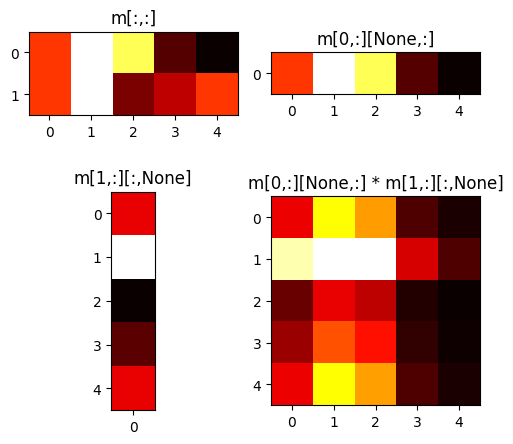

In [18]:
import torch
from matplotlib import pyplot as plt

m = torch.randn(2,5).abs()
dot_product = (m[0,:] * m[1,:]).sum()
outer_product = m[0,:][None,:] * m[1,:][:,None]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5), dpi=100)
def color_mat(ax, m, title):
    ax.set_title(title)
    ax.imshow(m, cmap='hot', vmax=1.5, interpolation='nearest')
    ax.get_xaxis().set_ticks(range(m.shape[1]))
    ax.get_yaxis().set_ticks(range(m.shape[0]))
color_mat(ax1, m, 'm[:,:]')
color_mat(ax2, m[0,:][None,:], 'm[0,:][None,:]')
color_mat(ax3, m[1,:][:,None], 'm[1,:][:,None]')
color_mat(ax4, outer_product, 'm[0,:][None,:] * m[1,:][:,None]')
fig.tight_layout()
fig.show()

In [26]:
a = torch.tensor([[1.0],[2.0],[3.0]])
b = torch.tensor([[4.0],[5.0],[6.0]])

outer_product = a @ b.T
dot_product = a.T @ b
# check
print(outer_product)
print(dot_product)

print("=====================")

print(f"outer product: {torch.mm(a, b.T)}")
print(f"dot product: {torch.mm(a.T, b)}")


tensor([[ 4.,  5.,  6.],
        [ 8., 10., 12.],
        [12., 15., 18.]])
tensor([[32.]])
outer product: tensor([[ 4.,  5.,  6.],
        [ 8., 10., 12.],
        [12., 15., 18.]])
dot product: tensor([[32.]])


In [27]:
import torch
print("CUDA available: ", torch.cuda.is_available())

CUDA available:  False


In [ ]:
device = torch.device("cpu")
model.to(device)